In [ ]:
# !pip install git+https://github.com/huggingface/transformers.git

In [ ]:
# !pip install --upgrade 'pandas<2'
# np.__version__,  pd.__version__

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
from PIL import Image
import pandas as pd
from glob import iglob
import re
from datetime import datetime
import random
import cv2
from copy import copy
from transformers import Mask2FormerForUniversalSegmentation
from importlib import reload
from glob import iglob
import os
from sklearn.manifold import TSNE
import seaborn as sns
from functools import partial
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ["WORLD_SIZE"] = "1"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim.lr_scheduler import _LRScheduler
# from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image


import sys
sys.path.append('../src')
import utils as ut
import dataset as ds


from transformers.utils import logging
logging.set_verbosity_error()

/home/rafael/miniconda3/envs/jupyterai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:

def fill_zeros(x, dec=4):
    if len(x) < dec:
        x += '0' * (dec-len(x))
    return x


def get_loader(set_='val', long=512):
    val_ds = ut.SimpleDataset(annotation_file=f'../data/FCDD-long{long}/{set_}paths.txt')
    val_loader = DataLoader(val_ds, batch_size=1)
    return val_loader


def count_images_that_have_class(dloader, ix):
    total = 0
    for _, labels in dloader:
        total += (labels==ix).any().item()

    return total


# Load models

In [ ]:
def find_logdir(model, long):
    fpaths = list(iglob(f'../logs/{model}*+long{long}*/model.last.pth', recursive=True))
    fpaths.sort()
    return fpaths[-1]

In [ ]:

modelnames = ['m2f', 'pplite', 'deeplab', 'hrnet']
modelnames = ['m2f', 'deeplab', 'hrnet']
longs = [256, 512, 1024, 1536, 2048]

log_dicts = {}
for n in modelnames:
    log_dicts[n] = {}
    for l in longs:
        log_dicts[n][l] = find_logdir(n, l)


print(log_dicts)

In [ ]:
log_dicts['hrnet']

In [ ]:

def instantiate_m2f():
    model = ut.MyMask2Former.from_pretrained(
            "facebook/mask2former-swin-base-IN21k-ade-semantic",
            id2label=ds.IDs('mocamba').id2label,
            ignore_mismatched_sizes=True
    )
    return model


def instantiate_pplite():
    from super_gradients.training import models
    from super_gradients.common.object_names import Models

    model = models.get(
        model_name=Models.PP_LITE_T_SEG75,
        arch_params={"use_aux_heads": True},
        num_classes=len(ds.mocamba_classnames),
    )
    return model


def instantiate_hrnet():
    sys.path.append("../../HRNet-Semantic-Segmentation/lib/")
    from config import update_config, config
    import models
    from core.criterion import CrossEntropy, OhemCrossEntropy
    from types import SimpleNamespace
    args = SimpleNamespace()
    args.cfg = '../../HRNet-Semantic-Segmentation/experiments/ade20k/seg_hrnet_ocr_w48_520x520_ohem_sgd_lr2e-2_wd1e-4_bs_16_epoch120.yaml'
    args.opts = [
        'TEST.MODEL_FILE', '../../HRNet-Semantic-Segmentation/pretrained_models/hrnet_ocr_cs_trainval_8227_torch11.pth',
        'DATASET.TEST_SET', 'list/ade20k/testval.lst',
        'DATASET.NUM_CLASSES', len(ds.mocamba_classnames),
    ]
    update_config(config, args)
    config['MODEL']['PRETRAINED'] = ''

    model = models.seg_hrnet_ocr
    model.BatchNorm2d_class = model.BatchNorm2d = nn.BatchNorm2d
    model = model.get_seg_model(config)
    # print(f'config.MODEL.ALIGN_CORNERS: {config.MODEL.ALIGN_CORNERS}')
    # print(f'config.TEST.OUTPUT_INDEX: {config.TEST.OUTPUT_INDEX}')
    return model


def instantiate_deeplab():
    import segmentation_models_pytorch as smp
    model = smp.DeepLabV3Plus(
        encoder_name="resnet50", encoder_weights="imagenet",
        in_channels=3, classes=len(ds.mocamba_classnames)
    )
    return model


def load_model(name, long):
    func_name = f'instantiate_{name}()'
    model = eval(func_name)

    modelpath = find_logdir(name, long)
    state = torch.load(modelpath, weights_only=False)['state']
    model.load_state_dict(state)
    model.eval().cuda();
    return model


In [ ]:

@torch.no_grad()
def get_hrnet_segmap(model, inp):
    pred = model(inp.cuda())[-1]
    pred = F.interpolate(pred, size=inp.shape[-2:], mode='bilinear', align_corners=True)
    pred = pred.argmax(1, keepdim=True).long()
    return pred


def get_CM_fromloader_hrnet(dloader, model, n_classes):
    CM_abs = np.zeros((n_classes, n_classes), dtype=int)

    for inp_im, inp_label in dloader:
        test_preds = get_hrnet_segmap(model, inp_im)
        for pr_i, y_i in zip(test_preds.cpu(), inp_label.cpu()):
            CM_abs += ut.get_CM(pr_i, y_i, n_classes)

    pred_P = CM_abs.sum(axis=0)
    gt_P = CM_abs.sum(axis=1)
    true_P = np.diag(CM_abs)

    CM_iou = true_P / (pred_P + gt_P - true_P)
    miou = np.nanmean(CM_iou)
    return miou, CM_iou, CM_abs


def get_CM_fromloader_pplite(dloader, model, n_classes, pad=0, set_='train'):

    model.eval()
    CM_abs = np.zeros((n_classes, n_classes), dtype=int)
    for inp_im, inp_label in dloader:
        long = max(inp_im.shape)
        remainder = (144/256)*long % 32
        pad = int(32 - remainder)

        inp_im = F.pad(inp_im, (0,0,pad,0))
        test_preds = model(inp_im.cuda())[0].argmax(1, keepdim=True).cpu()
        test_preds = test_preds[..., pad:,:]

        for pr_i, y_i in zip(test_preds, inp_label.cpu()):
            CM_abs += ut.get_CM(pr_i, y_i, n_classes)

    pred_P = CM_abs.sum(axis=0)
    gt_P = CM_abs.sum(axis=1)
    true_P = np.diag(CM_abs)

    CM_iou = true_P / (pred_P + gt_P - true_P)
    miou = np.nanmean(CM_iou)
    return miou, CM_iou, CM_abs



In [ ]:
dict_get_CM_fromloader = {
    'm2f': ut.get_CM_fromloader,
    'deeplab': partial(ut.get_CM_fromloader, deeplab=True),
    'hrnet': get_CM_fromloader_hrnet,
    'pplite': get_CM_fromloader_pplite,
}

In [ ]:
for n in modelnames:
    print(n)
    try:
        m = load_model(n, 256)
    except Exception as e:
        print(e)
        break

# Compute metrics

In [ ]:

long = 512
set_ = 'val'


fpath = f'../data/FCDD-long{long}/{set_}paths.txt'
train_ds = ut.SimpleDataset(annotation_file=fpath)
train_loader = DataLoader(train_ds, batch_size=3, shuffle=False)


fpath = f'../data/FCDD-long{long}/{set_}paths.txt'
val_ds = ut.SimpleDataset(annotation_file=fpath)
val_loader = DataLoader(val_ds, batch_size=1)

In [ ]:
for i in range(17):
    x=count_images_that_have_class(val_loader, i)
    print(str(i).rjust(2), ds.mocamba_classnames[i].rjust(15), str(x).rjust(3))

In [ ]:
# tmp=[]
# for inp_im, inp_label in train_loader:
    # tmp.append(inp_label.max())
    # break

ixs = [23, 27, 22, 20]
inp_im = torch.stack([train_ds[i][0] for i in ixs])
inp_label = torch.stack([train_ds[i][1] for i in ixs])

# inp_im, inp_label = train_ds[27]
# inp_im = inp_im[None]
# inp_label = inp_label[None]


dummy_im = inp_im.clone()[:6]
dummy_label = inp_label.clone()[:6]
dummy_label.unique()


colorizer = ut.TorchColorizer(max(ds.rtk2mocamba)+1)

ims = ut.Normalize.reverse(dummy_im)
labels = colorizer(dummy_label)
alpha = .2
blend = (1-alpha)*ims + alpha*labels

tmp = torch.concat([ims, labels, blend], axis=-2)
tmp = tmp.moveaxis(0,-2).flatten(-2,-1).permute(1,2,0)
tmp = ut.float_to_uint8(tmp.numpy())
Image.fromarray(tmp)

In [ ]:
Image.fromarray(tmp).save('outs/fig_mocamba_sample1.eps')

# Evaluating model

In [ ]:
miou_results = {}
iou_results = {}

for modelname in modelnames[:]:
    miou_results[modelname] = {}
    iou_results[modelname] = {}

    for long_train in longs[:]:
        miou_results[modelname][long_train] = {}
        iou_results[modelname][long_train] = {}

        model = load_model(modelname, long_train)
        get_CM_fromloader = dict_get_CM_fromloader[modelname]

        for long_eval in longs[:]:
        # for long_eval in [long_train]:
            miou_results[modelname][long_train][long_eval] = {}
            iou_results[modelname][long_train][long_eval] = {}

            for set_ in ['val', 'train'][:]:
                miou_results[modelname][long_train][long_eval][set_] = {}
                iou_results[modelname][long_train][long_eval][set_] = {}
                print(modelname, long_train, long_eval, set_)

                dataloader = get_loader(set_, long_eval)
                miou, CM_iou, _ = get_CM_fromloader(dataloader, model, len(ds.mocamba_classnames))

                miou_results[modelname][long_train][long_eval][set_] = np.round(miou*100,1)
                iou_results[modelname][long_train][long_eval][set_] = np.round(CM_iou*100,1)

In [ ]:

dfiou = []
for k, d in iou_results.items():
    for k2, d2 in d.items():
        for k3, v in d2.items():
            tmp = pd.DataFrame.from_dict(v).T.reset_index()
            # break
            tmp.columns = ['set_'] + list(ds.mocamba_classnames.values())
            tmp['model'] = k
            tmp['train'] = k2
            tmp['eval'] = k3
            dfiou.append(tmp)


dfiou = pd.concat(dfiou).reset_index(drop=True)
dfiou.to_pickle('metrics/final-metrics.pkl')

In [15]:
modelnames = ['m2f', 'pplite', 'deeplab', 'hrnet']
longs = [256, 512, 1024, 1536, 2048]

In [16]:
dfiouM = dfiou.melt(id_vars=['model', 'train', 'eval', 'set_'], var_name='class', value_name='miou')
cats = pd.DataFrame(data={'category': ds.mocamba_cats.values(), 'class': ds.mocamba_classnames.values()})
dfiouM = dfiouM.merge(cats, 'left', on='class')
dfiouM.sample(2)

,model,train,eval,set_,class,miou,category
1410,m2f,512,256,val,Hard sand,66.2,Surfaces
2736,hrnet,1536,1536,val,Soft sand,51.4,Surfaces


## Overall mIoU perfomance across the resolution

In [17]:
fig = True
# fig = False

# exclude = ['Animals', 'Obstacles']
# exclude = ['Animals', 'Cracks', 'Potholes', 'Obstacles']
exclude = ['Animals', 'Speed bump', 'Cracks']
exclude = []

variables = [c for c in ds.mocamba_classnames.values() if c not in exclude]
print(len(variables))
tmp = dfiou.query('train == eval and set_ == "val" and model not in []').melt(['set_', 'model', 'train']).query('variable in @variables')
# tmp = dfiou.query('eval == 2048 and set_ == "val"').melt(['set_', 'model', 'train']).query('variable in @variables')
tmp = tmp.groupby(['model', 'train'])['value'].mean().to_frame().reset_index()
tmp.pivot(index=['train'], columns='model', values='value').reset_index().round(1)

tmp['train'] = tmp['train'].astype(int)
tmp['value'] = tmp['value'].astype(np.float32)
tmp

17


,model,train,value
0,deeplab,256,42.335293
1,deeplab,512,48.835293
2,deeplab,1024,49.605881
3,deeplab,1536,51.099998
4,deeplab,2048,52.635296
5,hrnet,256,42.235294
6,hrnet,512,48.941177
7,hrnet,1024,50.588234
8,hrnet,1536,50.911766
9,hrnet,2048,52.241177


In [18]:

txt = tmp.copy()
txt['value'] = txt['value'].apply(lambda x: np.round(x, 1))
txt = txt.pivot(index='train', columns='model', values='value').reset_index()
txt['train'] = txt['train'].astype(int).astype(str)
txt = txt.apply(lambda r: ' & '.join(map(str, r)) + ' \\\\', axis=1).values.tolist()
txt = '\n'.join(txt)
print(txt)


256 & 42.3 & 42.2 & 44.4 & 39.4 \\
512 & 48.8 & 48.9 & 51.2 & 43.9 \\
1024 & 49.6 & 50.6 & 57.4 & 47.7 \\
1536 & 51.1 & 50.9 & 60.1 & 47.6 \\
2048 & 52.6 & 52.2 & 60.4 & 49.2 \\


<Figure size 2000x400 with 0 Axes>

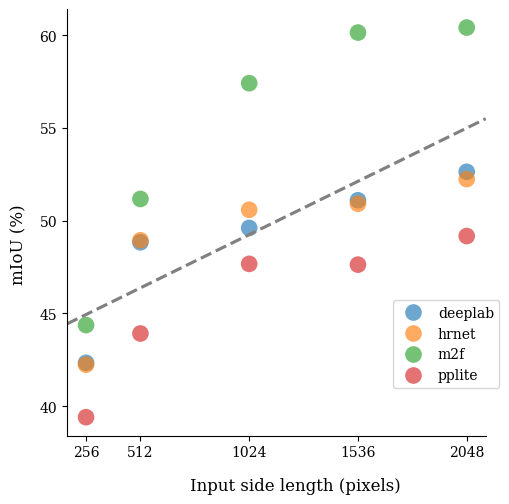

In [19]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

plt.figure(figsize=(20,4))
g = sns.catplot(data=tmp, x="train", y="value", hue="model", native_scale=True, zorder=1, jitter=False, size=12, alpha=.65)
g._legend.set_title("");
sns.move_legend(g, "center", ncol=1, title='', frameon=True, bbox_to_anchor=(.75,.30))
sns.regplot(data=tmp, x="train", y="value", scatter=False, order=1, ci=False, truncate=False, color='.5', line_kws={"linestyle": "--"});

tmp2 = tmp.melt(id_vars=['train', 'model'], var_name='class', value_name='miou')
delta = 1
ylim = (tmp2['miou'].min() - delta, tmp2['miou'].max() + delta)
g.set(xticks=longs, xlabel="", ylabel="", ylim=ylim)
g.fig.supxlabel("Input side length (pixels)", y=.0)#, fontsize=labelsize+1)
g.fig.supylabel("mIoU (%)", x=0.03)#, fontsize=labelsize+1)

plt.xticks(ticks=longs);
# plt.xlabel('');
# plt.ylabel('');
# plt.savefig('outs/fig_resolution_vs_miou.pdf', format='pdf')

## Evaluating mIoU perfomance from the minor classes

In [ ]:
# !rm outs/*.eps outs/*.svg

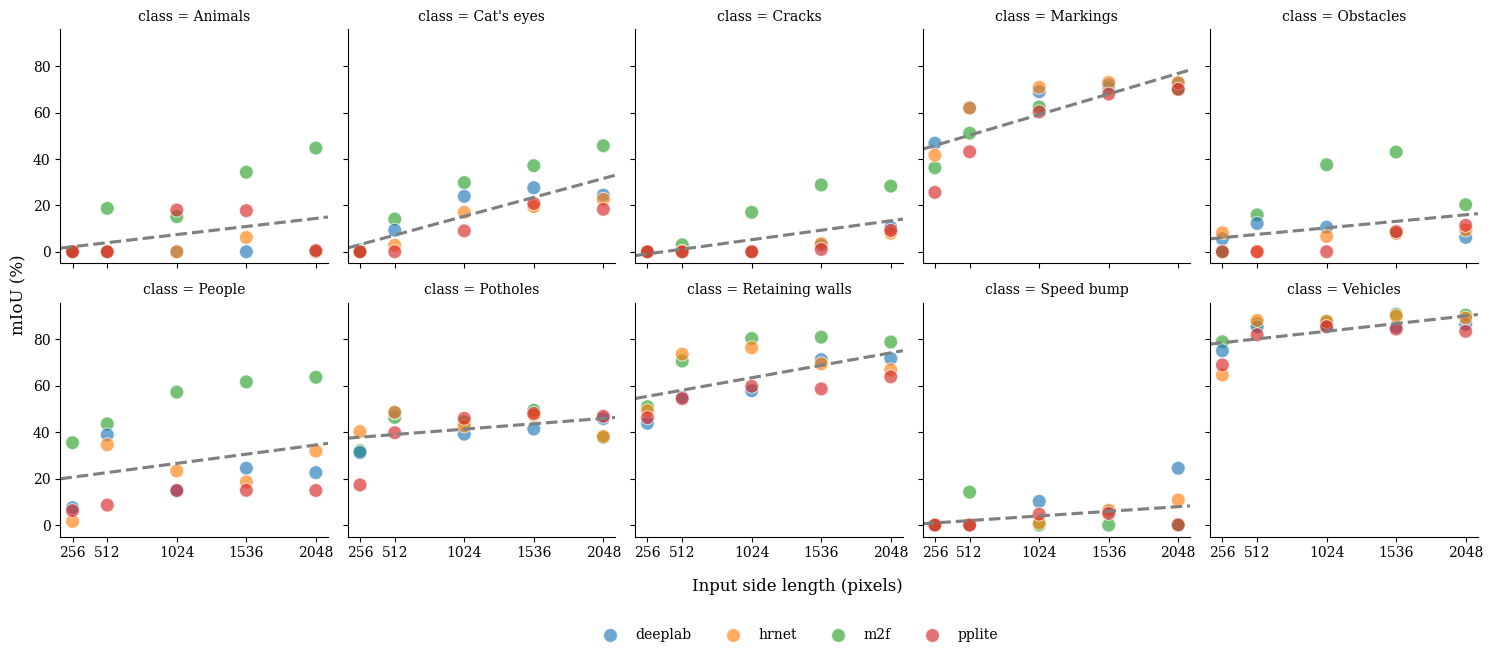

In [27]:
reload(ds)
# exclude = ['Animals', 'Obstacles']
# exclude = ['Animals', 'Cracks', 'Pothole', 'Obstacles']
# exclude = ["Speed bump"]
exclude = ['Ego']
# exclude = []

# tmp = dfiou.query('train == eval and set_ == "train" and model not in ["m2f", "deeplab", "hrnet"]')
tmp = dfiou.query('train == eval and set_ == "val" and model not in [""]')
tmp = tmp.sort_values(['set_', 'train', 'eval'])

exclude += ['eval', 'set_']
# exclude += ['train']
exclude += ds.surfaces_names + ['Background']
tmp = tmp.drop(exclude, axis=1)

tmp2 = tmp.melt(id_vars=['train', 'model'], var_name='class', value_name='miou')


delta = 5
g = sns.FacetGrid(tmp2, col='class', sharey=True, sharex=True, col_wrap=5)
g.map(sns.scatterplot, 'train', 'miou', s=100, alpha=.65, hue=tmp2['model'], hue_order=tmp2.model.sort_values().unique())
g.map(sns.regplot, 'train', 'miou', scatter=False, order=1, ci=None, truncate=False, color='.5', line_kws={"linestyle": "--"});

ylim = (tmp2['miou'].min() - delta, tmp2['miou'].max() + delta)
g.set(xticks=longs, xlabel=None, ylabel=None, ylim=ylim)
# g.set(xticks=longs, xlabel=None)
# labelsize = 8
g.fig.supxlabel("Input side length (pixels)", y=.0)#, fontsize=labelsize+1)
g.fig.supylabel("mIoU (%)", x=0.010)#, fontsize=labelsize+1)
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', labelsize=labelsize)
#     ax.tick_params(axis='y', labelsize=labelsize)


g.add_legend()
sns.move_legend(g, "lower center", ncol=4, title='', frameon=False, bbox_to_anchor=(0.5, -0.1))

plt.savefig('outs/fig_resolution_vs_miou_byclass_minors.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

# tmp

## Evaluating mIoU perfomance from the surfaces

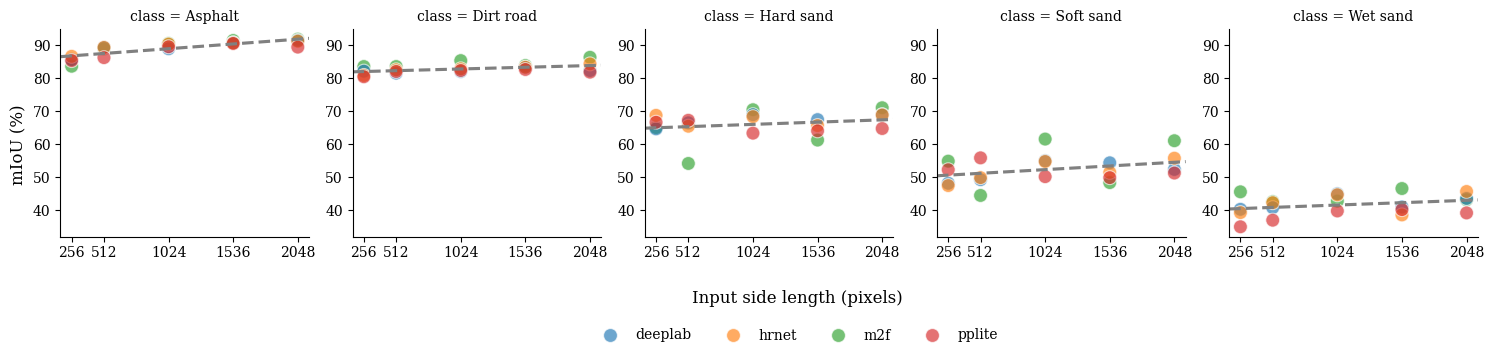

In [ ]:
# exclude = ['Animals', 'Obstacles']
# exclude = ['Animals', 'Cracks', 'Pothole', 'Obstacles']
# exclude = []

tmp = dfiou.query('train == eval and set_ == "val"')
tmp = tmp.sort_values(['set_', 'train', 'eval'])
tmp = tmp[ds.surfaces_names + ['train', 'model']]

tmp2 = tmp.melt(id_vars=['train', 'model'], var_name='class', value_name='miou')


g = sns.FacetGrid(tmp2, col='class', sharey=False, sharex=True, col_wrap=5)
g.map(sns.scatterplot, 'train', 'miou', s=100, alpha=.65, hue=tmp2['model'], hue_order=tmp2.model.sort_values().unique())
g.map(sns.regplot, 'train', 'miou', scatter=False, order=1, ci=None, truncate=False, color='.5', line_kws={"linestyle": "--"});

delta=3
ylim = (tmp2['miou'].min() - delta, tmp2['miou'].max() + delta)
g.set(xticks=longs, xlabel=None, ylabel=None, ylim=ylim)
labelsize = 10
g.fig.supxlabel("Input side length (pixels)", y=-.04)#, fontsize=labelsize+1)
g.fig.supylabel("mIoU (%)", x=0.01)#, fontsize=labelsize+1)
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', labelsize=labelsize)
#     ax.tick_params(axis='y', labelsize=labelsize)

g.add_legend()
sns.move_legend(g, "lower center", ncol=4, title='', frameon=False, bbox_to_anchor=(0.5, -0.2))



plt.savefig('outs/fig_resolution_vs_miou_byclass_surfaces.pdf', format='pdf', pad_inches=0.2, bbox_inches='tight')

# tmp

In [ ]:
tmp = dfiouM.query('train == eval').groupby(['set_', 'train', 'model'])['miou'].mean().to_frame().reset_index()
tmp['miou'] = tmp['miou'].apply(lambda x: np.round(x, 1))
tmp
# tmp.pivot(index='set_', columns='train', values='miou').reset_index()

In [ ]:
tmp = dfiouM.groupby(['set_', 'train', 'eval', 'model'])['miou'].mean().to_frame().reset_index()
tmp['miou'] = tmp['miou'].apply(lambda x: np.round(x, 1))
tmp
# tmp = tmp.pivot(index=['train', 'eval'], columns='set_', values='miou').reset_index()
# tmp.sort_values(['train', 'eval'], ascending=True)

In [ ]:
dfiouM

In [ ]:
tmp = dfiouM.query('train == eval and miou > 0')
a = tmp.groupby(['category', 'class'])['miou'].std().to_frame().reset_index()
a['category'] = a['category'].apply(lambda x: x if x == "Surfaces" else "Not Surfaces")

b = tmp.query('set_ == "val"').groupby(['class'])['miou'].std().to_frame().reset_index()
c = tmp.query('set_ == "train"').groupby(['class'])['miou'].std().to_frame().reset_index()

tmp = a.merge(b, 'left', on='class', suffixes=['_all', '_val']).merge(c, 'left', on='class')
tmp = tmp.rename(columns={'miou': 'miou_train'})
for col in ['miou_all', 'miou_val', 'miou_train']:
    tmp[col] = tmp[col].round(1)

tmp.sort_values('miou_val', ascending=False)

In [ ]:
tmp2 = tmp.query('`class` != "Background"').dropna().sort_values(['category', 'class'])
tmp

In [ ]:
import matplotlib
print(matplotlib.get_backend())


In [ ]:
tmp2 = tmp.query('`class` != "Background"').dropna().sort_values(['category', 'class'])
tmp2 = tmp2.rename(columns={'class': 'Class', 'miou_val': 'mIoU - std. deviation', 'category': 'Category'})

ax = sns.catplot(
    tmp2, kind='bar', x='Class', y='mIoU - std. deviation', hue='Category',
    aspect=2.5,
)
ax.set(xlabel=None)
tickslabel = [label.get_text() for label in ax.ax.get_xticklabels()]
tickslabel = [x if x != 'Retaining walls' else "Retaining w." for x in tickslabel]
tickslabel = [x if x != 'Speed bump' else "Speed b." for x in tickslabel]


ax.ax.set_xticklabels(tickslabel, rotation=90)
ax.set(xlabel=None, ylabel="mIoU std. dev. (%)")
# sns.move_legend(ax, "lower center", frameon=False, title=None, ncol=2, bbox_to_anchor=(0.5, -0.175))

plt.savefig('outs/fig_category_std.pdf', format='pdf')


## Quais classes se beneficiam mais com uma avaliação em maior resolução?

In [ ]:
# tmp.sort_values('diff', ascending=False)
# results.query('set_ == "val" and model == "DeepLabv3+"')

In [ ]:
results = []

for h1, h2 in zip(longs, longs[1:]):
    tmp = dfiouM.query('train == @h1 and eval in [@h1, @h2]')
    tmp = tmp.pivot(index=['set_', 'class', 'model'], columns='eval', values='miou').reset_index()
    tmp['diff'] = tmp[h2] - tmp[h1]
    tmp['h1xh2'] = f'{h1}x{h2}'
    tmp1 = tmp.pivot(index=['set_', 'model', 'h1xh2'], columns='class', values='diff').copy().reset_index()
    results.append(tmp1)
    # break

results = pd.concat(results)
results.groupby('set_').mean(numeric_only=True).round(1).T.reset_index().sort_values('val', ascending=False)

## Quais classes se beneficiam mais com uma avaliação em menor resolução?

In [ ]:
results = []
for h1, h2 in zip(longs[1:], longs[:]):
    tmp = dfiouM.query('train == @h1 and eval in [@h1, @h2]')
    tmp = tmp.pivot(index=['set_', 'model', 'class'], columns='eval', values='miou').reset_index()
    tmp['diff'] = tmp[h2] - tmp[h1]
    tmp['h1xh2'] = f'{h1}x{h2}'
    tmp1 = tmp.pivot(index=['set_', 'model', 'h1xh2'], columns='class', values='diff').copy().reset_index()
    results.append(tmp1)

results = pd.concat(results)
results.groupby('set_').mean(numeric_only=True).round(1).T.reset_index().sort_values('train', ascending=False)

## Compara correlação entre classes

In [ ]:
clset = ds.surfaces_names
tmp = dfiouM.query('`class` in @clset and set_ == "val"')
tmp = tmp.groupby(['class', 'set_', 'model', 'eval'])['miou'].mean().to_frame().reset_index()
tmp['miou'] = tmp['miou'].apply(lambda x: np.round(x, 1))
tmp.sort_values(['class', 'miou'], ascending=False)

In [ ]:
tmp = dfiouM.query('`class` in @ds.surfaces_names and set_ == "val" and train == eval')
# tmp = tmp.query('set_ == "train"')
tmp = tmp.pivot(index=['train', 'set_', 'model', 'eval'], columns='class', values='miou').reset_index()


dfcor = tmp.drop(['set_', 'train', 'model', 'eval'], axis=1).corr().round(2)
dfcor.reset_index()

In [ ]:

npcor = dfcor.values
npcor[np.eye(len(npcor))==1] = 0
ixs1 = npcor.argmax(0)
best_pairs = dfcor.columns[ixs1]
best_values = [x[i] for i, x in zip(ixs1, npcor)]


npcor[np.eye(len(npcor))==1] = 1
ixs2 = npcor.argmin(0)
worst_pairs = dfcor.columns[ixs2]
worst_values = [x[i] for i, x in zip(ixs2, npcor)]


surfaces = pd.DataFrame(data={
    'surface': dfcor.columns,
    'best_pairs': best_pairs,
    'best_values': best_values,
    'worst': worst_pairs,
    'worst_values': worst_values
})

tmp = surfaces.sort_values('surface')
tmp


In [ ]:

txt = tmp.copy()
txt['best_values'] = txt['best_values'].apply(str).apply(fill_zeros)
txt['worst_values'] = txt['worst_values'].apply(str).apply(fill_zeros)
txt = txt.apply(lambda r: ' & '.join(map(str, r)) + ' \\\\', axis=1).values.tolist()
txt = '\n'.join(txt)
print(txt)
# txt

# Plot Images

In [ ]:
from tqdm import tqdm


fpath = '../data/mocamba/ds-mocamba-v0.3.4-long512/trainpaths.txt'
# fpath = '../data/mocamba/ds-mocamba-v0.3.4-long1024/valpaths.txt'


with open(fpath, 'r') as f:
    valpaths = f.read().split('\n')[:-1]


In [ ]:
names = []
wet_quantity = []

for p in tqdm(valpaths):
    pgt = ut.get_gtpath(p)
    gt = ut.cv2_imread(pgt)
    cls, counts = np.unique(gt, return_counts=True)
    if 15 in cls:
        wet_quantity.append(counts[cls == 15])
    else:
        wet_quantity.append(0)

    major = cls[1:][np.argmax(counts[1:])]
    name = ds.mocamba_classnames[major]
    names.append(name)

names = np.array(names)
wet_quantity = np.array(wet_quantity)

In [ ]:

def get_surface_blend(name):
    if name == 'Wet sand':
        paths = np.array(valpaths)[np.argsort(wet_quantity)[::-1][:4]]
    else:
        pos = np.argwhere(names == name).ravel()
        pos2 = np.random.choice(pos, 4, replace=False)
        paths = np.array(valpaths)[pos2]
    ims = np.concatenate(list(map(ut.cv2_imread, paths)), axis=1)
    gts = np.concatenate(list(map(ut.cv2_imread, map(ut.get_gtpath, paths))), axis=1)
    colorizer = ut.Colorizer(len(ds.mocamba_classnames))
    gts = ut.float_to_uint8(colorizer(gts))
    alpha=.7
    blend = ut.float_to_uint8(ims/255*alpha + (1-alpha)*gts/255)
    tmp1 = np.concatenate([ims, gts, blend], axis=0)
    return tmp1


tmp = []
for n in ds.surfaces_names[:1]:
    tmp.append(get_surface_blend(n))
    tmp = np.concatenate(tmp, axis=0)
    nn = n.replace(' ', '-')
    Image.fromarray(tmp).save(f'outs/fig_mocamba_sample_{nn}_appendix.eps')
    tmp = []

In [ ]:
tmp = get_surface_blend('Asphalt')
nn = n.replace(' ', '-')
Image.fromarray(tmp)#.save(f'outs/fig_mocamba_sample_{nn}_appendix.eps')


In [ ]:
Image.fromarray(tmp).save(f'outs/fig_mocamba_sample_{nn}_appendix.eps')
